## Model Prediction after 2018 results

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-deep')

In [3]:
# load data
data = pd.read_csv('results_2017_2018.csv')

In [4]:
# compute total points
data['points_total'] = data['points_televoting'] + data['points_jury']

In [5]:
# compute rank columns
data['rank_total'] = data.groupby('round')['points_total'].rank(ascending=False)
data['rank_jury'] = data.groupby('round')['points_jury'].rank(ascending=False)
data['rank_televoting'] = data.groupby('round')['points_televoting'].rank(ascending=False)

# check if points are set correctly (0 is correct) (there might be countries with rank_calc = X.5 in case of tie)
sum(abs(data['rank_source'] - data['rank_total']))

1.0

### Explore data

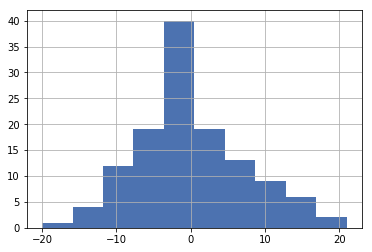

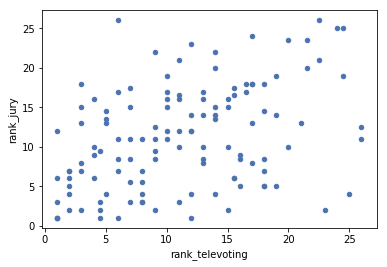

In [17]:
# difference between ranks from jury and televoting
data['rank_diff'] = data['rank_televoting'] - data['rank_jury']
(data['rank_diff']).hist(bins=10)

# scatter plot
ax1 = data.plot.scatter('rank_televoting', 'rank_jury')

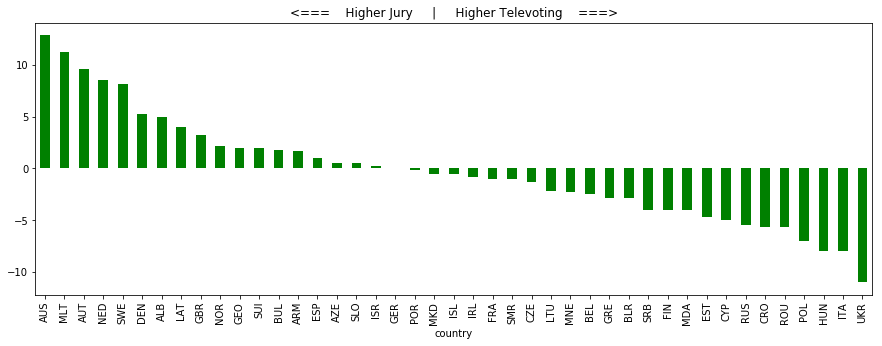

In [7]:
# which countries suffer more differences?
data.groupby('country')['rank_diff'].agg('mean').sort_values(ascending=False).plot.bar(color='green', 
                                                                                       title='<===    Higher Jury     |     Higher Televoting    ===>', 
                                                                                       figsize=(15,5))


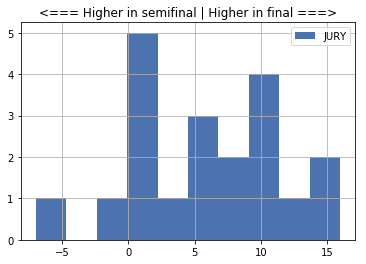

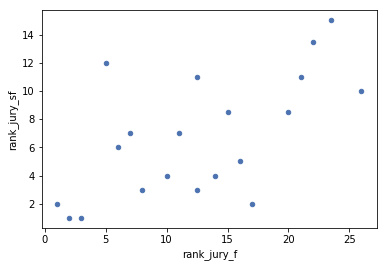

In [16]:
# compare jury votes/rank in semifinal vs final

data_final = data[data['round']=='2018_final']
data_semifinals = data[(data['round']=='2018_semi1') | (data['round']=='2018_semi2')]

# join data
data_merged = pd.merge(data_final, data_semifinals, left_on='country', right_on='country', how='inner', suffixes=('_f','_sf'))

# plot histogram
ax = (data_merged['rank_jury_f'] - data_merged['rank_jury_sf']).hist(label='JURY')
#(data_merged['rank_televoting_f'] - data_merged['rank_televoting_sf']).hist(label='TELE', ax=ax)
ax.legend()
ax.set_title('<=== Higher in semifinal | Higher in final ===>')

# plot scatter
ax1 = data_merged.plot.scatter('rank_jury_f', 'rank_jury_sf')

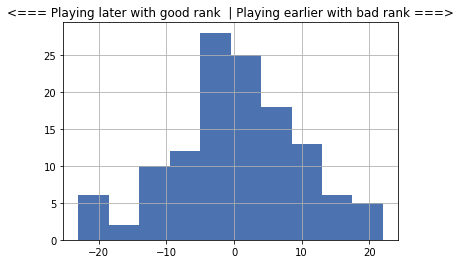

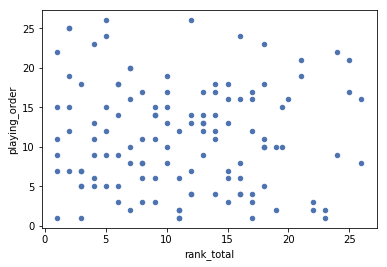

In [36]:
# how the playing order affects to the final rank?
data['rank_draw_diff'] = data['rank_total'] - data['playing_order']
ax = (data['rank_draw_diff']).hist(bins=10)
ax.set_title('<=== Playing later with good rank  | Playing earlier with bad rank ===>')

# scatter plot
ax1 = data.plot.scatter('rank_total', 'playing_order')

## Feature Engineering

In [37]:
# compute sum of tweets per round
tweets_sum = data.groupby('round')['tweets'].agg('sum')
positive_sum = data.groupby('round')['positive'].agg('sum')
neutral_sum = data.groupby('round')['neutral'].agg('sum')
negative_sum = data.groupby('round')['negative'].agg('sum')

# add features for percentages of x_tweets per round
data['tweets_perc'] = data.apply(lambda r : r['tweets'] / tweets_sum[r['round']], axis=1)
data['positive_perc'] = data.apply(lambda r : r['positive'] / positive_sum[r['round']], axis=1)
data['neutral_perc'] = data.apply(lambda r : r['neutral'] / neutral_sum[r['round']], axis=1)
data['negative_perc'] = data.apply(lambda r : r['negative'] / negative_sum[r['round']], axis=1)

# add features of logarithm of x_tweets
data['tweets_log'] = np.log(1 + data['tweets'])
data['positive_log'] = np.log(1 + data['positive'])
data['neutral_log'] = np.log(1 + data['neutral'])
data['negative_log'] = np.log(1 + data['negative'])

In [38]:
# normalize playing order
data['num_contestants'] =  data[['round','playing_order']].groupby('round').transform(np.max)
data['playing_order_norm'] = data['playing_order'] / data['num_contestants']

In [39]:
# create labels 'isTopN'
data['isTop5_jury'] = data.apply(lambda r: 1 if r['rank_jury']<=5 else 0, axis=1)
data['isTop10_jury'] = data.apply(lambda r: 1 if r['rank_jury']<=10 else 0, axis=1)
data['isTop5_televoting'] = data.apply(lambda r: 1 if r['rank_jury']<=5 else 0, axis=1)
data['isTop10_televoting'] = data.apply(lambda r: 1 if r['rank_jury']<=10 else 0, axis=1)
data['isTop5_total'] = data.apply(lambda r: 1 if r['rank_total']<=5 else 0, axis=1)
data['isTop10_total'] = data.apply(lambda r: 1 if r['rank_total']<=10 else 0, axis=1)

## TopN Prediction: Logistic Regression

In [40]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import randint

In [41]:
# set label to predict
isTopN = 'isTop10_total'

# set the features to analyze in the model
#features = ['negative', 'neutral', 'positive', 'tweets']
#features = ['negative_log', 'neutral_log', 'positive_log', 'tweets_log']
features = ['negative_perc', 'neutral_perc', 'positive_perc', 'tweets_perc', 'playing_order_norm']
features_string = ' + '.join(features)

# create input matrix and outut array
y, X = dmatrices('{} ~ {}'.format(isTopN, features_string), data, return_type = 'dataframe')

# sklearn split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(0,1000))
print('X_train: {}\nX_test:  {}\ny_train: {} {}%\ny_test:  {} {}%'.format(
    len(X_train),
    len(X_test),
    len(y_train), int(100*y_train.sum()/len(y_train)),
    len(y_test), int(100*y_test.sum()/len(y_test))
))

# Linear Regression model with sklearn
regularization = 0.001
model = LogisticRegression(fit_intercept = True, C = 1/regularization)
regressor = model.fit(X_train, y_train.values.ravel())

# predict train & test
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# print scores
print('\nClassification performance metrics (train)')
print(' Accuracy: {}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print(' ROC AUC:  {}\n'.format(metrics.roc_auc_score(y_train, y_train_pred)))
print('\nClassification performance metrics (test)')
print(' Accuracy: {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print(' ROC AUC:  {}\n'.format(metrics.roc_auc_score(y_test, y_test_pred)))

# print feature relationship
features_tmp = np.insert(features,0,'intercept')
print(pd.DataFrame(list(zip(features_tmp, model.coef_.ravel())), columns=['features','coefs']))

# compute the new predicted score using the feature weights modeled in Logistic Regression
data['predicted_score'] = np.dot(X.values, model.coef_.T)

# compare predicted as topN
data[data['round']=='2018_final'][['round','country','tweets_perc','positive_perc','neutral_perc','negative_perc','playing_order',isTopN,'predicted_score']].sort_values(by=['predicted_score'], ascending=False).head(10)

X_train: 100
X_test:  25
y_train: 100 49%
y_test:  25 44%

Classification performance metrics (train)
 Accuracy: 0.7
 ROC AUC:  0.6994797919167667


Classification performance metrics (test)
 Accuracy: 0.72
 ROC AUC:  0.7207792207792209

             features      coefs
0           intercept  -1.511329
1       negative_perc -10.172926
2        neutral_perc  -1.709512
3       positive_perc  29.244111
4         tweets_perc  41.246368
5  playing_order_norm   0.447744


,round,country,tweets_perc,positive_perc,neutral_perc,negative_perc,playing_order,isTop10_total,predicted_score
111,2018_final,ISR,0.083664,0.063532,0.098796,0.112979,22,1,2.858077
106,2018_final,CYP,0.051674,0.058178,0.044542,0.027936,25,1,2.391594
104,2018_final,GBR,0.055776,0.079772,0.054189,0.080346,9,0,2.367075
108,2018_final,CZE,0.072406,0.036941,0.129483,0.035600,14,1,2.213068
105,2018_final,IRL,0.037964,0.060409,0.035996,0.021261,24,0,1.956638
107,2018_final,FIN,0.036114,0.062639,0.026738,0.026947,17,0,1.782993
102,2018_final,ITA,0.034108,0.049076,0.025508,0.018789,26,1,1.543687
118,2018_final,MDA,0.041174,0.047827,0.029846,0.035847,19,1,1.497140
117,2018_final,HUN,0.044184,0.039707,0.037356,0.051174,21,0,1.249488
109,2018_final,EST,0.038700,0.043901,0.038651,0.029172,6,1,1.109240


### Improvements

- random trees